# Mask R-CNN - Inspect Ballon Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
ROOT_DIR = os.path.abspath("../../")
print(ROOT_DIR)

/home/hengam2/DeepLearning/project2/Mask_RCNN


In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.balloon import balloon

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
BALLON_WEIGHTS_PATH = "/home/hengam2/DeepLearning/project2/Mask_RCNN/mask_rcnn_balloon.h5"  # TODO: update this path

In [3]:
from mrcnn import visualize_cv

## Configurations

In [23]:
config = balloon.BalloonConfig()
BALLOON_DIR = os.path.join(ROOT_DIR, "balloon_dataset/balloon")

In [24]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASk = False

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [6]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [7]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [25]:
# Load validation dataset
dataset = balloon.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 13
Classes: ['BG', 'balloon']


## Load Model

In [9]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
weights_path = BALLON_WEIGHTS_PATH 

# Or, load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/hengam2/DeepLearning/project2/Mask_RCNN/mask_rcnn_balloon.h5


## Run Detection

Run Mask R-CNN model which is trained on balloon dataset over the RGB images to detect and segment balloon.

/home/hengam2/anaconda3/envs/maskrcnn/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


image ID: balloon.3825919971_93fb1ec581_b.jpg (9) /home/hengam2/DeepLearning/project2/Mask_RCNN/balloon_dataset/balloon/val/3825919971_93fb1ec581_b.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (6,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (6, 4)                min:  154.00000  max:  613.00000  int32
gt_mask                  shape: (56, 56, 6)           min:    0.00000  max:    1.00000  bool


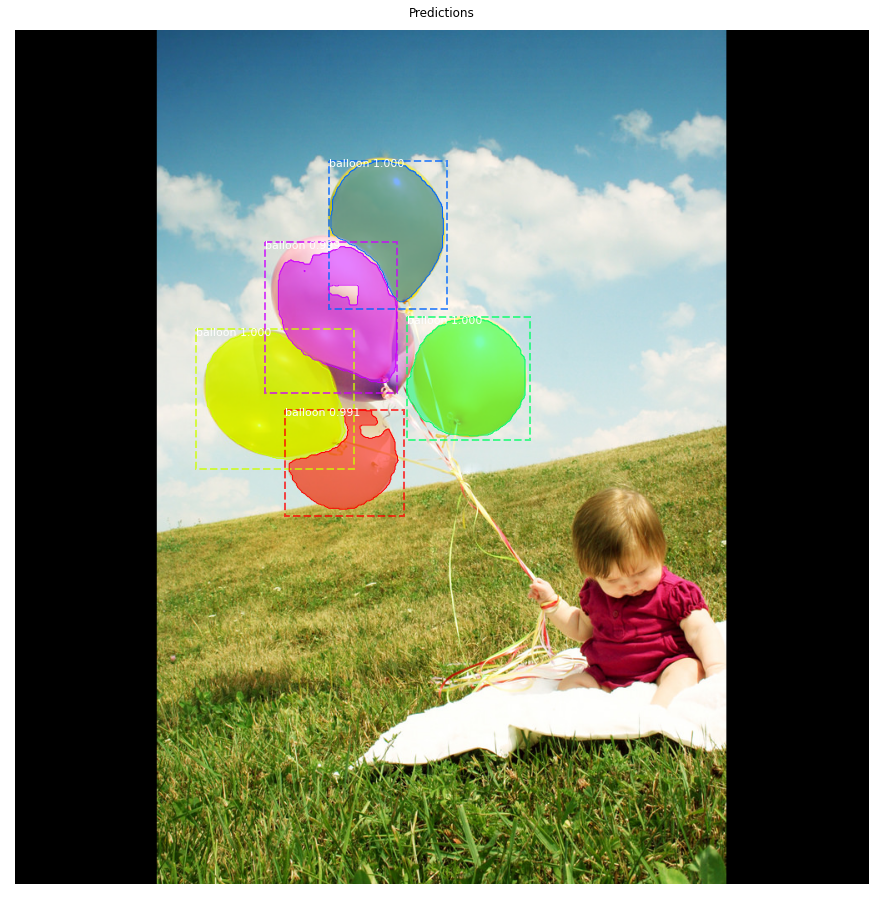

In [27]:
#image_id = random.choice(dataset.image_ids)
image_id = 9
#print(image_id)

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Color Splash

This is for illustration. You can call `balloon.py` with the `splash` option to get better images without the black padding.

At first the Mask R-CNN detect and segment the ballon then the color splash change the image to grayscale except the segmented balloon

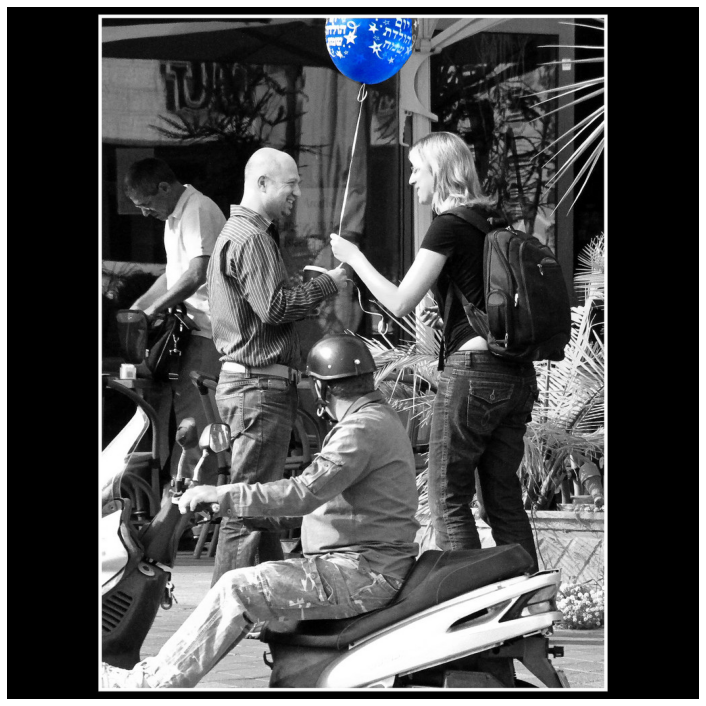

In [17]:
splash = balloon.color_splash(image, r['masks'])
display_images([splash], cols=1)

# Balloon detection on Video

Define some function for converting video to images and applied Mask R-CNN on the obtained images.

In [27]:
print(ROOT_DIR)

def print_fps(video):
  # Find OpenCV version
  (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

  if int(major_ver)  < 3 :
      fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
      print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
  else :
      fps = video.get(cv2.CAP_PROP_FPS)
      print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))
    
batch_size = 1

def get_masked_image(image, result):
  """
  Applies masks from the results to the given image
  
  """
  boxes = result['rois']
  masks = result['masks']
  
  N = boxes.shape[0]
  if not N:
    print("\n*** No instances to display *** \n")

  colors = visualize.random_colors(N)
  masked_image = image.astype(np.uint32).copy()

  for i in range(N):
      color = colors[i]

      # Mask
      mask = masks[:, :, i]
      masked_image = visualize.apply_mask(masked_image, mask, color)
  return masked_image.astype(np.uint8)

/home/hengam2/DeepLearning/project2/Mask_RCNN


Convert video to images by getting the fps (frame per second).

In [28]:
import cv2

capture = cv2.VideoCapture(os.path.join(ROOT_DIR, "vid.mp4"))
  
print_fps(capture)
  
try:
    if not os.path.exists(VIDEO_SAVE_DIR):
        os.makedirs(VIDEO_SAVE_DIR)
except OSError:
    print ('Error: Creating directory of data')
frames = []
frame_count = 0
  
while True:
    ret, frame = capture.read()
      # Bail out when the video file ends
    if not ret:
        break
          
      # Save each frame of the video to a list
    frame_count += 1
    frames.append(frame)
    print('frame_count :{0}'.format(frame_count))
    if len(frames) == batch_size:
        results = model.detect(frames, verbose=0)
        print('Predicted')
        for i, item in enumerate(zip(frames, results)):
            frame = item[0]
            r = item[1]
              #seg_map = combine_masks(frame, r)
              #seg_image = label_to_color_image(seg_map)
              #frame = merge_images(seg_image, frame)
            frame = get_masked_image(frame, r)
            name = '{0}.jpg'.format(frame_count + i - batch_size)
            name = os.path.join(VIDEO_SAVE_DIR, name)
            cv2.imwrite(name, frame)
          # Clear the frames array to start the next batch
        frames = []

capture.release()

Frames per second using video.get(cv2.CAP_PROP_FPS) : 23.976023976023978
frame_count :1
Predicted
frame_count :2
Predicted
frame_count :3
Predicted
frame_count :4
Predicted
frame_count :5
Predicted
frame_count :6
Predicted
frame_count :7
Predicted
frame_count :8
Predicted
frame_count :9
Predicted
frame_count :10
Predicted
frame_count :11
Predicted
frame_count :12
Predicted
frame_count :13
Predicted
frame_count :14
Predicted
frame_count :15
Predicted
frame_count :16
Predicted
frame_count :17
Predicted
frame_count :18
Predicted
frame_count :19
Predicted
frame_count :20
Predicted
frame_count :21
Predicted
frame_count :22
Predicted
frame_count :23
Predicted
frame_count :24
Predicted
frame_count :25
Predicted
frame_count :26
Predicted
frame_count :27
Predicted
frame_count :28
Predicted
frame_count :29
Predicted
frame_count :30
Predicted
frame_count :31
Predicted
frame_count :32
Predicted
frame_count :33
Predicted
frame_count :34
Predicted
frame_count :35
Predicted
frame_count :36
Predicted


Convert the obtained images to video

In [30]:
import glob
import os

def make_video(outvid, images=None, fps=30, size=None,
               is_color=True, format="FMP4"):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
 
    The function relies on http://opencv-python-tutroals.readthedocs.org/en/latest/.
    By default, the video will have the size of the first image.
    It will resize every image to this size before adding them to the video.
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

images = list(glob.iglob(os.path.join(VIDEO_SAVE_DIR, '*.*')))
# Sort the images by integer index
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))

outvid = os.path.join(ROOT_DIR, "final.mp4")
make_video(outvid, images, fps=20)

<VideoWriter 0x7f5448934a10>

# Convert balloon dataset to grayscale images

In [15]:
import cv2
import os

# Specify input and output directories
input_folder = '/home/hengam2/DeepLearning/project2/Mask_RCNN/balloon_dataset/balloon/train'
output_folder = '/home/hengam2/DeepLearning/project2/Mask_RCNN/balloon_dataset/balloon/train2'

# List image files in the input folder
image_files = os.listdir(input_folder)

# Loop through image files
for image_file in image_files:
    
    # Read the image
    image_path = os.path.join(input_folder, image_file)
    img = cv2.imread(image_path)
    
    if img is not None:
    # Convert to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Save the grayscale image with the same filename in the output folder
        output_path = os.path.join(output_folder, image_file)
        cv2.imwrite(output_path, gray_img)
    else:
        print("Image not loaded or empty.")
    
    

Image not loaded or empty.


'Image not loaded or empty.' is printed beacuse one of the file in this repository is not image and it is the json file of these image annotations.

In [19]:
import cv2
import os

# Specify input and output directories
input_folder = '/home/hengam2/DeepLearning/project2/Mask_RCNN/balloon_dataset/balloon/val'
output_folder = '/home/hengam2/DeepLearning/project2/Mask_RCNN/balloon_dataset/balloon/val2'

# List image files in the input folder
image_files = os.listdir(input_folder)

# Loop through image files
for image_file in image_files:
    
    # Read the image
    image_path = os.path.join(input_folder, image_file)
    img = cv2.imread(image_path)
    
    if img is not None:
    # Convert to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Save the grayscale image with the same filename in the output folder
        output_path = os.path.join(output_folder, image_file)
        cv2.imwrite(output_path, gray_img)
    else:
        print("Image not loaded or empty.")
    
    

Image not loaded or empty.


'Image not loaded or empty.' is printed beacuse one of the file in this repository is not image and it is the json file of these image annotations.

In [20]:
from samples.balloon import balloon2

config = balloon2.BalloonConfig()
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASk = False

config = InferenceConfig()
config.display()


/home/hengam2/DeepLearning/project2/Mask_RCNN
None

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MA

In [21]:

# Load validation dataset
dataset = balloon2.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "val2")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

/home/hengam2/DeepLearning/project2/Mask_RCNN/balloon_dataset/balloon/val2
{'24631331976_defa3bb61f_k.jpg668058': {'fileref': '', 'size': 668058, 'filename': '24631331976_defa3bb61f_k.jpg', 'base64_img_data': '', 'file_attributes': {}, 'regions': {'0': {'shape_attributes': {'name': 'polygon', 'all_points_x': [916, 913, 905, 889, 868, 836, 809, 792, 789, 784, 777, 769, 767, 777, 786, 791, 769, 739, 714, 678, 645, 615, 595, 583, 580, 584, 595, 614, 645, 676, 716, 769, 815, 849, 875, 900, 916, 916], 'all_points_y': [515, 583, 616, 656, 696, 737, 753, 767, 777, 785, 785, 778, 768, 766, 760, 755, 755, 743, 728, 702, 670, 629, 588, 539, 500, 458, 425, 394, 360, 342, 329, 331, 347, 371, 398, 442, 504, 515]}, 'region_attributes': {}}}}, '16335852991_f55de7958d_k.jpg1767935': {'fileref': '', 'size': 1767935, 'filename': '16335852991_f55de7958d_k.jpg', 'base64_img_data': '', 'file_attributes': {}, 'regions': {'0': {'shape_attributes': {'name': 'polygon', 'all_points_x': [588, 617, 649, 673, 692,

2


/home/hengam2/anaconda3/envs/maskrcnn/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


image ID: balloon.14898532020_ba6199dd22_k.jpg (2) /home/hengam2/DeepLearning/project2/Mask_RCNN/balloon_dataset/balloon/val/14898532020_ba6199dd22_k.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (9,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (9, 4)                min:   11.00000  max: 1009.00000  int32
gt_mask                  shape: (56, 56, 9)           min:    0.00000  max:    1.00000  bool


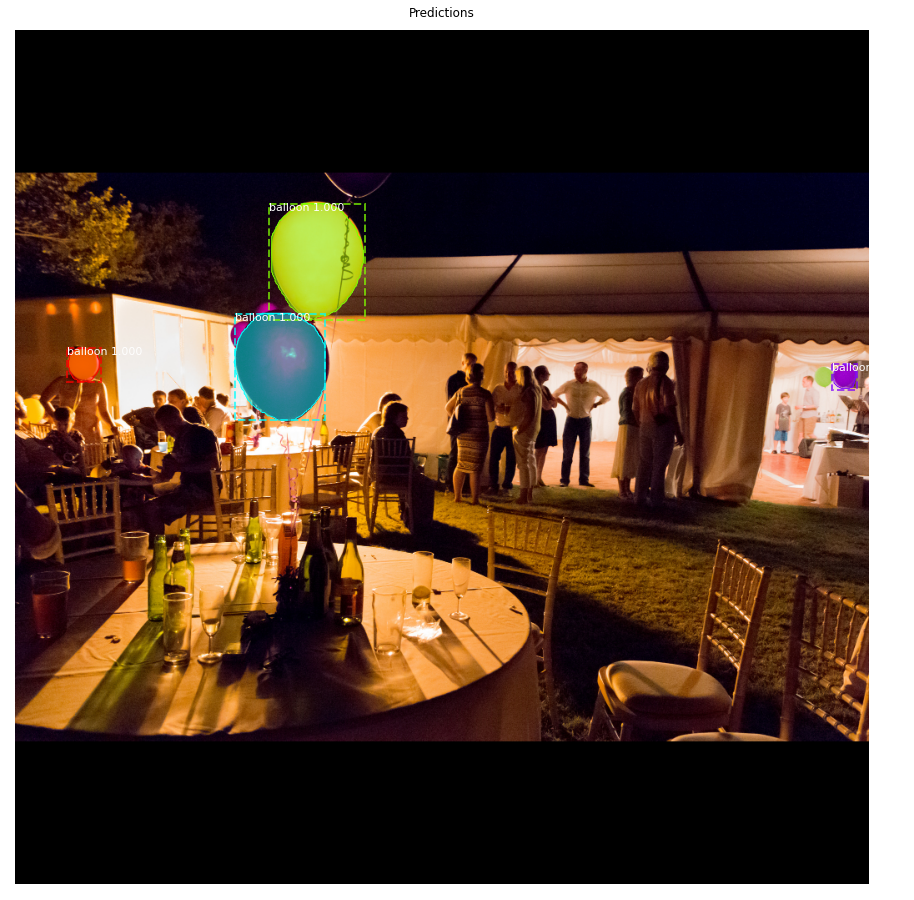

In [26]:
#image_id = random.choice(dataset.image_ids)
image_id = 2
print(image_id)

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Mask R-CNN for balloon detection in grayscale images

2
image ID: balloon.14898532020_ba6199dd22_k.jpg (2) /home/hengam2/DeepLearning/project2/Mask_RCNN/balloon_dataset/balloon/val2/14898532020_ba6199dd22_k.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64


/home/hengam2/anaconda3/envs/maskrcnn/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (9,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (9, 4)                min:   11.00000  max: 1009.00000  int32
gt_mask                  shape: (56, 56, 9)           min:    0.00000  max:    1.00000  bool


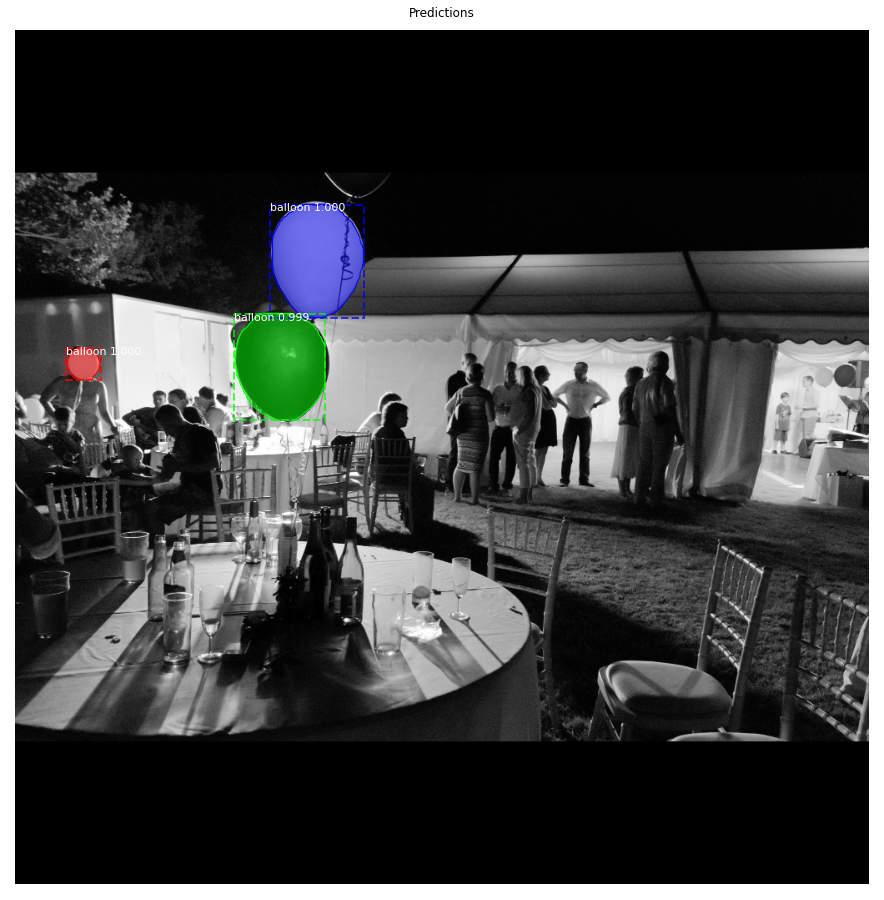

In [22]:
#image_id = random.choice(dataset.image_ids)
image_id = 2
print(image_id)

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)